In [3]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:1')
torch.cuda.set_device(device)
import numpy as np
from tqdm.auto import tqdm
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
from TNModels import Ising3D

In [5]:
model=Ising3D(Ising3D.get_default_params())
T0=model.get_T0()
T0_op,checkerboard=model.get_observables()['magnetization']

In [6]:
from HOSVD import _HOSVD_layer_3D,gauge_invariant_norm
from HOTRGZ2 import HOTRG_layers,trace_tensor,_forward_layer,forward_observable_tensor,trace_two_tensors

def _XTRG_layer_3D(Ta,Tb,max_dim):
    Tn,layer=_HOSVD_layer_3D(Ta,Tb,max_dim=max_dim)
    Tn=contract('abcdio->ioabcd',Tn)
    return Tn,layer

def _forward_XTRG_layer_3D(Ta,Tb,layer):
    T=_forward_layer(Ta,Tb,layer)
    T=contract('abcdio->ioabcd',T)
    return T


def XTRG_layers(T0,max_dim,nLayers,return_tensors=False):
    T,logTotal=T0,0
    Ts,logTotals=[T],[0]
    layers=[]
    print('Generating XTRG layers')
    for i in tqdm(list(range(nLayers)),leave=False):
        norm=gauge_invariant_norm(T)
        T=T/norm
        logTotal=2*(logTotal+norm.log())

        T,layer=_XTRG_layer_3D(T,T,max_dim=max_dim)

        layers.append(layer)
        Ts.append(T);logTotals.append(logTotal)
    print('XTRG layers generated')
    return (layers,Ts,logTotals) if return_tensors else layers

def partial_trace_XTRG_tensor(T):
    return contract('aaijkl->ijkl',T)

def forward_XTRG_observable_tensor(T0,T0_op,layers,checkerboard=False,
                                   return_layers=False,cached_Ts=None):
    T,logTotal=T0,0
    T_op=T0_op
    if return_layers:
        Ts,logTotals=[T],[0]
        T_ops=[T_op]
    for iLayer,layer in tqdm(enumerate(layers),leave=False):
        norm=gauge_invariant_norm(T)
        T,T_op=T/norm,T_op/norm
        logTotal=2*(logTotal+norm.log())

        if cached_Ts:
            T1=cached_Ts[iLayer+1]
        else:
            T1=_forward_XTRG_layer_3D(T,T,layer)
        T2=_forward_XTRG_layer_3D(T,T_op,layer)
        T3=_forward_XTRG_layer_3D(T_op,T,layer)
        T3=-T3 if checkerboard and iLayer==0 else T3
        T,T_op=T1,(T2+T3)/2
        if return_layers:
            Ts.append(T);logTotals.append(logTotal)
            T_ops.append(T_op)
    return (Ts,T_ops,logTotals) if return_layers else (T,T_op,logTotal)


In [12]:
data=[]
for beta in np.linspace(0.20,0.24,11):
    model=Ising3D({'beta': beta})
    T0=model.get_T0()
    T0_op,checkerboard=model.get_observables()['magnetization']

    layers,Ts,logTotals=XTRG_layers(T0,max_dim=16,nLayers=10,return_tensors=True)
    Ts,T_ops,logTotals=forward_XTRG_observable_tensor(T0,T0_op,layers,checkerboard=checkerboard,
                                                        return_layers=True,cached_Ts=Ts)
    
    T10=partial_trace_XTRG_tensor(Ts[-1])
    T10_op=partial_trace_XTRG_tensor(T_ops[-1])
    layers1,Ts1,logTotals1=HOTRG_layers(T10,max_dim=24,nLayers=20,return_tensors=True)
    Ts1,T_ops1,logTotals1=forward_observable_tensor(T10,T10_op,layers1,checkerboard=checkerboard,
                                                        return_layers=True,cached_Ts=Ts1)
    logTotal=logTotals[-1]*2**20+logTotals1[-1]+trace_tensor(Ts1[-1]).log()
    logTotal=logTotal/2**30

    magnetization=trace_two_tensors(T_ops1[-1],T_ops1[-1])/trace_two_tensors(Ts1[-1],Ts1[-1])


    print('beta=',beta,'logTotal=',logTotal.item(),'magnetization=',magnetization.item())
    data.append({'beta':beta,'logTotal':logTotal.item(),'magnetization':magnetization.item()})


Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.24 logTotal= 0.7862322705020336 magnetization= 0.018578197833302668
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.244 logTotal= 0.7896534811555743 magnetization= 0.017934286278473915
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.248 logTotal= 0.7931330194381152 magnetization= 0.005549967443215266
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.252 logTotal= 0.7972740439031099 magnetization= 0.030902209239894844
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.256 logTotal= 0.8020975817325058 magnetization= 0.04981596055939205
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.26 logTotal= 0.8079646948467488 magnetization= 0.08514984678635602
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.264 logTotal= 0.8151673795111487 magnetization= 0.13186209848279168
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.268 logTotal= 0.8260447531940887 magnetization= 0.22816314089931716
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.272 logTotal= 0.8376619532853554 magnetization= 0.31616593809477483
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.276 logTotal= 0.8525524382326071 magnetization= 0.42245527240389674
Generating XTRG layers


  0%|          | 0/10 [00:00<?, ?it/s]

XTRG layers generated


0it [00:00, ?it/s]

Generating HOTRG layers


  0%|          | 0/20 [00:00<?, ?it/s]

HOTRG layers generated


0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

beta= 0.28 logTotal= 0.8612582327395342 magnetization= 0.45493127445976306


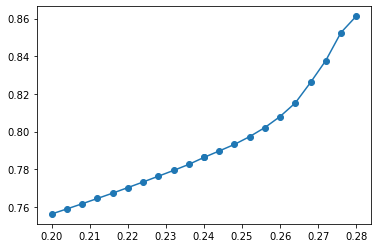

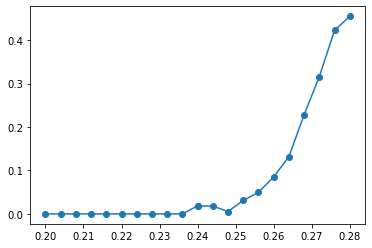

In [13]:
curve=pd.DataFrame(data)
plt.plot(curve['beta'],curve['logTotal'],'o-')
plt.show()

plt.plot(curve['beta'],curve['magnetization'],'o-')
plt.show()


In [ ]:
def XTRG_3D_defect(T0,T0_op,max_dim,nLayers):
    T,T_op,logTotal=T0,T0_op,0
    for i in tqdm(range(nLayers),leave=False):
        norm=gauge_invariant_norm(T)
        logTotal=2*(logTotal+norm.log())
        T,T_op=T/norm,T_op/norm
        T_op=_XTRG_layer_3D(T_op,T,max_dim=max_dim)[0]
        T=_XTRG_layer_3D(T,T,max_dim=max_dim)[0]
    return T,T_op


In [11]:
T,T_op=XTRG_3D_defect(T0,T0_op,max_dim=16,nLayers=20)
Y0=contract('aaijkl->ijkl',T)
Y0_op=contract('aaijkl->ijkl',T_op)

In [13]:
from HOTRGZ2 import forward_observable_tensors,HOTRG_layers,trace_tensor


layers,Ys,logTotals=HOTRG_layers(Y0,max_dim=16,nLayers=30,return_tensors=True)

Generating HOTRG layers


  0%|          | 0/30 [00:00<?, ?it/s]

HOTRG layers generated


In [15]:
filename='./data/ising3d_xtrg_X16_corr'
T0_op,checkerboard=model.get_observables()['magnetization']
data=[]
for r in tqdm(np.geomspace(2,1023,32)):
    theta=np.random.uniform(0,.5*np.pi)
    dx,dy=int(r*np.sin(theta)),int(r*np.cos(theta))
    x1,y1=np.random.randint(0,1024-dx),np.random.randint(0,1024-dy)
    x2,y2=x1+dx,y1+dy
    T,T_op,logTotal=forward_observable_tensors(Y0,[Y0_op,Y0_op],[(x1,y1),(x2,y2)],layers,cached_Ts=Ys,user_tqdm=False)
    corr=trace_tensor(T_op)/trace_tensor(T)
    data.append({'corr':corr.item(),
                 'x1':x1,'y1':y1,
                 'x2':x2,'y2':y2,
    })
# save 
torch.save(data,filename)


  0%|          | 0/32 [00:00<?, ?it/s]

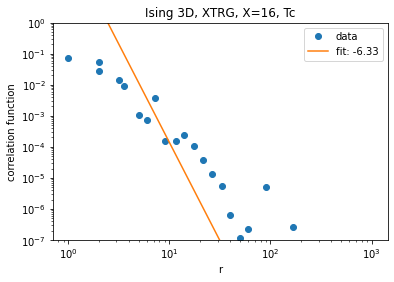

In [16]:
curve=pd.DataFrame(torch.load('./data/ising3d_xtrg_X16_corr'))
curve['r']=np.sqrt((curve['x1']-curve['x2'])**2+(curve['y1']-curve['y2'])**2)

import scipy.stats
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(np.log(curve['r']),np.log(np.abs(curve['corr'])))


plt.plot(curve['r'],np.abs(curve['corr']),'o',label='data')
plt.plot(curve['r'],np.exp(intercept)*curve['r']**slope,label=f'fit: {slope:.2f}')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('correlation function')
plt.ylim([1e-7,1])
plt.title('Ising 3D, XTRG, X=16, Tc')
plt.show()